### A.2 Joint Training of Image and Semantic Embedding

In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import pandas as pd
from torch.utils.data import Dataset
import random
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import optim
import sys

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### Download dataset from scratch

In [3]:
# transform = transforms.Compose(
#     [
#         transforms.ToPILImage(),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=(0.5,), std=(0.5,)),
#     ]
# )
# trainset = datasets.MNIST("data/", download=False, train=True, transform=transform)
# valset = datasets.MNIST("data/", download=False, train=False, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
# valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

#### Creating the required network

In [18]:
class CNN(nn.Module):
    def __init__(self, alpha, output_dim, batch_size):
        super().__init__()
        self.batch_size = batch_size
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5)
        self.lin = nn.Linear(20 * 20 * 32, output_dim)
        self.encoder_hidden_layer = nn.Linear(7, 5)
        self.encoder_hidden_layer_2 = nn.Linear(5, 5)

    def forward_cnn(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.lin(x.view(-1, 20 * 20 * 32))
        return x

    def forward_sem(self, x):
        x = torch.relu(self.encoder_hidden_layer(x))
        x = torch.relu(self.encoder_hidden_layer_2(x))
        return x

    def forward(self, input1, input2):
        output1 = self.forward_cnn(input1)
        output2 = self.forward_sem(input2)
        return output1, output2

    def save(self, path):
        T.save(self.state_dict(), path)

    def load(self, path):
        self.load_state_dict(T.load(path))

In [5]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim=True)
        loss_contrastive = torch.mean(
            (1 - label) * torch.pow(euclidean_distance, 2)
            + (label)
            * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        )
        return loss_contrastive

#### Creating Training Dataset

In [6]:
class SiameseNetworkDataset(Dataset):
    def __init__(self, data, transform, classes_subset, shuffle=True):
        self.data = (
            data[data.label.isin(classes_subset)].sample(frac=1).reset_index(drop=True)
            if shuffle
            else data
        )
        self.transform = transform
        self.attributes = pd.read_csv("mnist_attributes.csv")

    def __getitem__(self, index):
        item = self.data.iloc[index]
        pixels = np.array(item[1:]).astype(np.uint8).reshape((28, 28))
        # we need to make sure approx 50% of images are in the same class
        label = -1
        should_get_same_class = random.randint(0, 1)
        attributes = None
        if should_get_same_class:
            label = 0
            # keep looping till the same class image is found
            attributes = (
                self.attributes[self.attributes.Digit == int(item[0])]
                .iloc[:, 1:]
                .values
            )
        else:
            label = 1
            while True:
                random_item = np.random.randint(low=1, high=10, size=1)
                if random_item != item[0]:
                    break
            attributes = (
                self.attributes[self.attributes.Digit == int(random_item)]
                .iloc[:, 1:]
                .values
            )

        if self.transform is not None:
            pixels = self.transform(pixels)

        return pixels, attributes, label

    def __len__(self):
        return len(self.data)

In [7]:
train = pd.read_csv("data/train.csv")
transformation = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,), std=(0.5,)),
    ]
)
train_split = 0.7
n_rows = len(train)
len_training = int(n_rows * train_split)
train_indexes = np.random.choice(len(train), size=len_training, replace=False)
train_dataset = SiameseNetworkDataset(
    train.iloc[train_indexes],
    transform=transformation,
    classes_subset=[0, 1, 2, 3, 4, 5, 6],
)
# validation_dataset = SiameseNetworkDataset(
#     train.iloc[~train_indexes], transform=transformation, classes_subset=[7, 9, 8]
# )

(array([[1, 1, 1, 1, 1, 1, 0]], dtype=int64), 0)

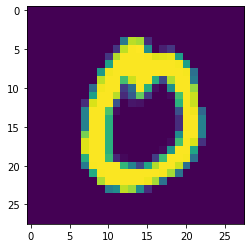

In [8]:
im = train_dataset[0]
plt.imshow(im[0].reshape(28, 28))
im[1], im[2]

In [9]:
batch_size = 16
n_iterations = 250
n_epochs = 10
learning_rate = 0.0001

In [20]:
cnn = CNN(alpha=learning_rate, batch_size=batch_size, output_dim=5).to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.0005)

In [21]:
cnn

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (lin): Linear(in_features=12800, out_features=5, bias=True)
  (encoder_hidden_layer): Linear(in_features=7, out_features=5, bias=True)
  (encoder_hidden_layer_2): Linear(in_features=5, out_features=5, bias=True)
)

In [22]:
cnn.train()
for epoch in range(0, 2):
    for i, (pixels, attributes, label) in enumerate(train_dataset):
        pixels, attributes, label = (
            torch.tensor(pixels.reshape(1, 1, 28, 28)).to(device),
            torch.tensor(attributes).float().to(device),
            label,
        )
        optimizer.zero_grad()
        output1, output2 = cnn.forward(pixels, attributes)
        loss_contrastive = criterion(output1, output2, label)
        loss_contrastive.backward()
        optimizer.step()
        if i % 500 == 0:
            print(
                "Epoch number {}\n Current loss {}\n".format(
                    epoch, loss_contrastive.item()
                )
            )

<ipython-input-22-c00cbb2884f0>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(pixels.reshape(1, 1, 28, 28)).to(device),


Epoch number 0
 Current loss 1.5724196434020996

Epoch number 0
 Current loss 1.5754878520965576

Epoch number 0
 Current loss 0.7049034833908081

Epoch number 0
 Current loss 1.178051471710205

Epoch number 0
 Current loss 1.080912709236145

Epoch number 0
 Current loss 0.7763777375221252

Epoch number 0
 Current loss 0.8219127655029297

Epoch number 0
 Current loss 1.059652328491211

Epoch number 0
 Current loss 0.6771239042282104

Epoch number 0
 Current loss 0.676023542881012

Epoch number 0
 Current loss 0.6118512749671936

Epoch number 0
 Current loss 1.4768859148025513

Epoch number 0
 Current loss 0.34465649724006653

Epoch number 0
 Current loss 0.7316420078277588

Epoch number 0
 Current loss 0.10235624760389328

Epoch number 0
 Current loss 1.8211919069290161

Epoch number 0
 Current loss 1.9178779125213623

Epoch number 0
 Current loss 1.0427056550979614

Epoch number 0
 Current loss 0.0

Epoch number 0
 Current loss 0.0

Epoch number 0
 Current loss 0.7766579389572144

Epo

#### Creating Validation Dataset

In [23]:
class DigitsDataset(Dataset):
    def __init__(self, data, transform, classes_subset, shuffle=True):
        self.data = (
            data[data.label.isin(classes_subset)].sample(frac=1).reset_index(drop=True)
            if shuffle
            else data
        )
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        item = self.data.iloc[index]
        pixels = np.array(item[1:]).astype(np.uint8).reshape((28, 28))
        label = item[0]
        if self.transform is not None:
            pixels = self.transform(pixels)

        return pixels, label

In [24]:
validation_dataset = DigitsDataset(
    train.iloc[~train_indexes], transform=transformation, classes_subset=[7, 9, 8]
)
attributes_df = pd.read_csv("data/mnist_attributes.csv")

7

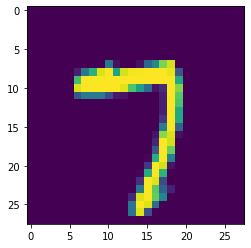

In [31]:
i = validation_dataset[10]
plt.imshow(i[0].reshape(28, 28))
i[1]

In [36]:
cnn.eval()
attrib = {}
with torch.no_grad():
    for r in attributes_df.to_numpy()[7 : 9 + 1]:
        output1 = cnn.forward_sem(torch.tensor(r[1:]).float().to(device))
        attrib[r[0]] = output1
attrib

{7: tensor([0.0000, 0.0000, 1.1880, 0.9647, 0.1244], device='cuda:0'),
 8: tensor([0.8560, 0.0000, 2.1143, 0.3307, 2.1965], device='cuda:0'),
 9: tensor([0.0000, 0.0000, 2.3853, 1.5444, 1.8408], device='cuda:0')}

In [39]:
cnn.eval()
with torch.no_grad():
    n_correct_attributes = 0
    pred_label = None
    for i, (pixels, label) in enumerate(validation_dataset):
        pixels = torch.tensor(pixels.reshape(1, 1, 28, 28)).to(device)
        output1 = cnn.forward_cnn(pixels)
        dist = sys.maxsize
        for k, v in attrib.items():
            z = F.pairwise_distance(output1, v).item()
            if z < dist:
                pred_label = k
                dist = z
        if pred_label == label:
            n_correct_attributes += 1
n_correct_attributes * 100.0 / len(validation_dataset)

<ipython-input-39-97be43735b71>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pixels = torch.tensor(pixels.reshape(1, 1, 28, 28)).to(device)


60.022547914317926

#### Saving the trained model

In [ ]:
checkpoint_dict = {"optimizer": optimizer.state_dict(), "model": cnn.state_dict()}
torch.save(checkpoint_dict, "A2")

#### Loading the trained model

In [ ]:
cnn.load_state_dict(torch.load("A2")["model"])